<a href="https://colab.research.google.com/github/jacobalmon/CS-478/blob/main/Homework/'Homework%203'/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

In [2]:
# Mounting Google Drive.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Task 1: Data Preparation
# Load the CIFAR-10 Dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize Pixel Values to [0 , 1].
x_train = x_train.astype("float32") / 255.0
x_test= x_test.astype("float32") / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [4]:
# Task 2: Model Design.
# Load EfficientNetB0 with Pretrained ImageNet Weights w/o Top Classification.
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze Pretrained Layers.
base_model.trainable = False

# Build Model.
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Reduce to a Single Vector.
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'), # Dense Layer.
    layers.Dropout(0.2), # Prevent Overfitting.
    layers.Dense(10, activation='softmax') # CIFAR-10 Output (10 Classes Total).
])

# Compile  Model.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of Model.
model.summary()

# Testing. (Delete Later)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385,197 (16.73 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [11]:
# Task 3: Training.
# Data Augmentation.
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Initialize Epochs & Batch Size.
epochs_init = 5
epoch_finetune = 15
batch_size = 64

# Training Custom Classification Layer.
history_init = model.fit(
    data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epochs_init,
    verbose=1
)

# Unfreeze Layers & Fine Tune Model.
base_model.trainable = True

# Compile Model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for Additioonal 15 Epochs.
history_finetune = model.fit(
    data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epoch_finetune,
    verbose=1
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8476 - loss: 0.4486 - val_accuracy: 0.1989 - val_loss: 2.9856
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.8512 - loss: 0.4390 - val_accuracy: 0.0985 - val_loss: 7.4057
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8562 - loss: 0.4272 - val_accuracy: 0.1004 - val_loss: 12.1671
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.8487 - loss: 0.4497 - val_accuracy: 0.4958 - val_loss: 1.5960
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8632 - loss: 0.4025 - val_accuracy: 0.1406 - val_loss: 4.0983
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 106ms/step - accuracy: 0.8617 - loss: 0.4091 - val_accuracy: 0.0931 - val_loss: 5.1943
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.8693 - loss: 0.3830 - val_accuracy: 0.1079 - val_loss: 4.9665
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8598 - loss: 0.4136 - va

In [13]:
# Save the Model.
model.save('/content/drive/MyDrive/cs478_model_hw3.keras', save_format='keras')

In [17]:
# Load the Model
model = load_model('/content/drive/MyDrive/cs478_model_hw3.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1029 - loss: 8.5184
Test Accuracy: 0.10289999842643738


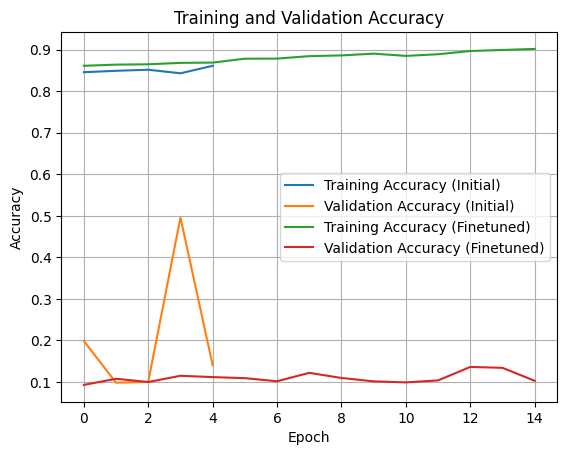

In [20]:
# Evaluating the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Plot Training & Validation Accuracy for both phases
plt.plot(history_init.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history_init.history['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Finetuned)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Finetuned)')

# Adding labels and title to the plot
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Displaying the legend and the plot
plt.legend()
plt.grid(True)
plt.show()